In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [2]:
train_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/train_FD001.txt" ,sep=" ",header=None)
train_1.drop(columns=[26,27],inplace=True)
train_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [19]:
test_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/test_FD001.txt",sep=" ",header=None)
test_1.drop(columns=[26,27],inplace=True)
test_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [4]:
rul_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/RUL_FD001.txt",sep=" ",header=None)
rul_1.drop(columns=[1],inplace=True)
rul_1

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [5]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
train_1.columns = columns


In [20]:
test_1.columns = columns

In [6]:
description = train_1.describe()
description.loc['std']

unit_number       2.922763e+01
time_in_cycles    6.888099e+01
setting_1         2.187313e-03
setting_2         2.930621e-04
TRA               0.000000e+00
T2                6.537152e-11
T24               5.000533e-01
T30               6.131150e+00
T50               9.000605e+00
P2                3.394700e-12
P15               1.388985e-03
P30               8.850923e-01
Nf                7.098548e-02
Nc                2.208288e+01
epr               4.660829e-13
Ps30              2.670874e-01
phi               7.375534e-01
NRf               7.191892e-02
NRc               1.907618e+01
BPR               3.750504e-02
farB              1.556432e-14
htBleed           1.548763e+00
Nf_dmd            0.000000e+00
PCNfR_dmd         0.000000e+00
W31               1.807464e-01
W32               1.082509e-01
Name: std, dtype: float64

In [7]:
#delete columns with constant values that do not carry information about the state of the unit
train_1.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [8]:
#Adding RUL column 
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    return df[df['time_in_cycles'] > factor]

In [9]:
train_1 = prepare_train_data(train_1)
train_1

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


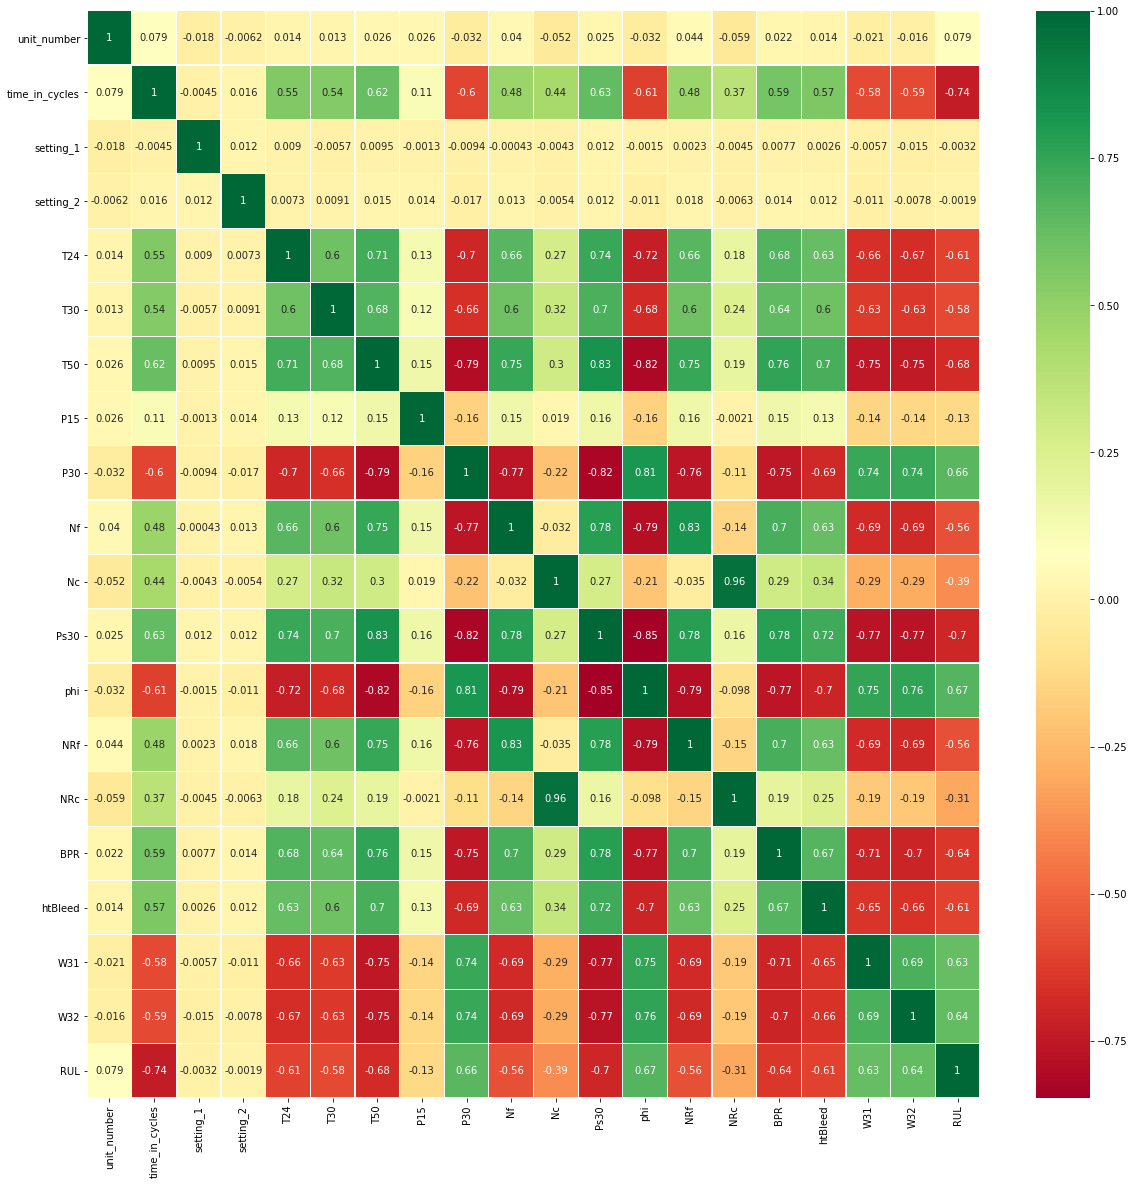

In [10]:
sns.heatmap(train_1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [12]:
df1 = train_1.loc[train_1["unit_number"] == 1]
df1

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,643.75,1602.38,1422.78,21.61,551.94,2388.31,9037.91,48.00,519.79,2388.23,8117.69,8.5207,396,38.51,22.9588,4
188,1,189,-0.0006,0.0002,644.18,1596.17,1428.01,21.61,550.70,2388.27,9044.55,48.08,519.58,2388.33,8117.51,8.5183,395,38.48,23.1127,3
189,1,190,-0.0027,0.0001,643.64,1599.22,1425.95,21.61,551.29,2388.29,9040.58,48.33,520.04,2388.35,8112.58,8.5223,398,38.49,23.0675,2
190,1,191,-0.0000,-0.0004,643.34,1602.36,1425.77,21.61,550.92,2388.28,9042.76,48.15,519.57,2388.30,8114.61,8.5174,394,38.45,23.1295,1


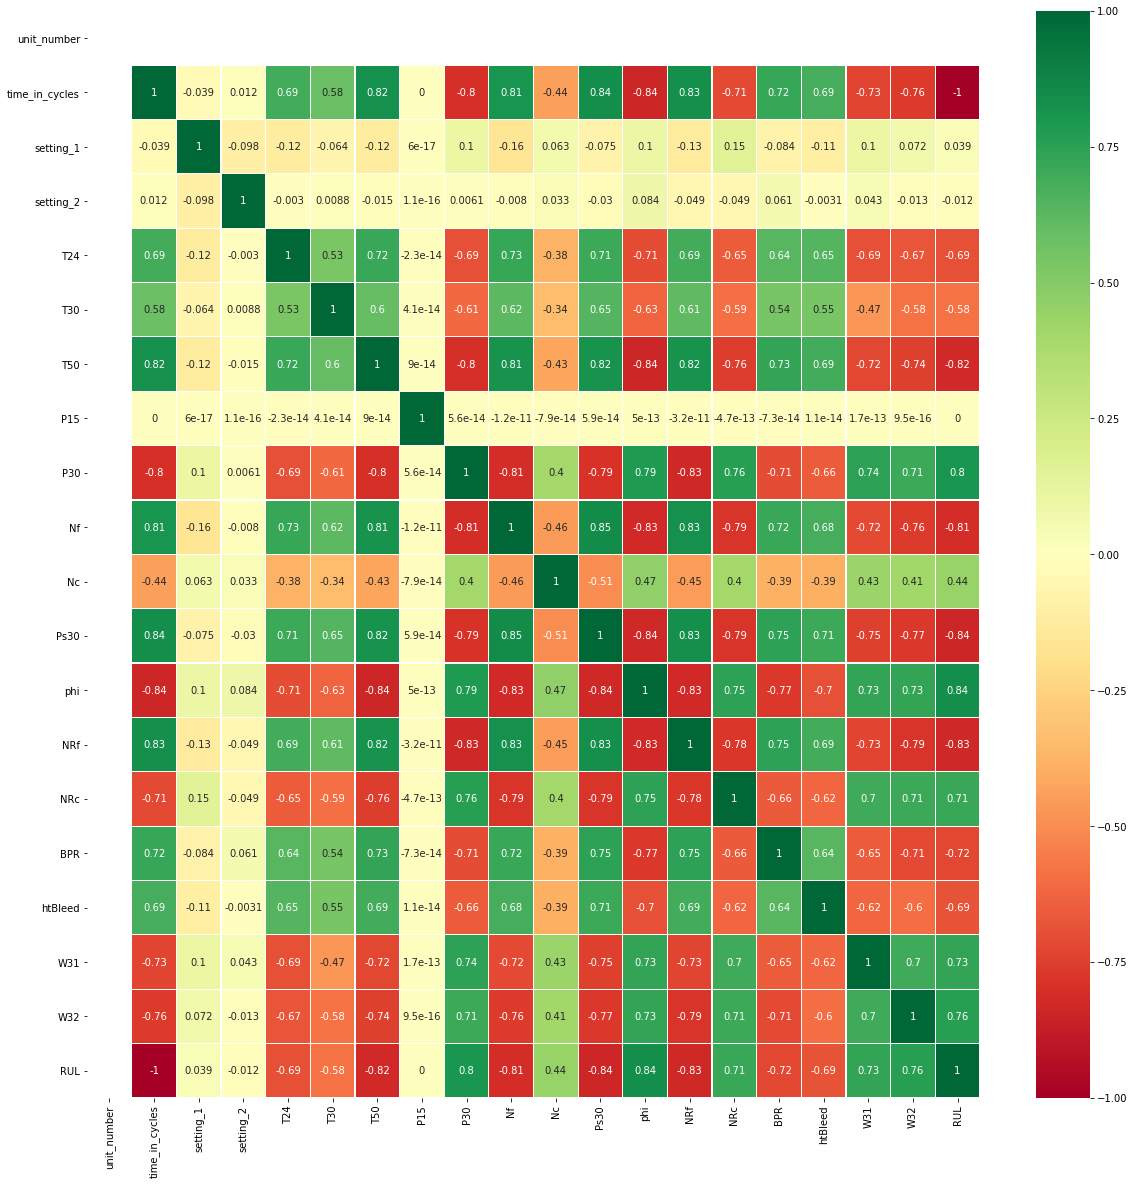

In [13]:
sns.heatmap(df1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [14]:
df1.drop(columns=['unit_number','setting_1','setting_2','P15','NRc'], inplace = True) 

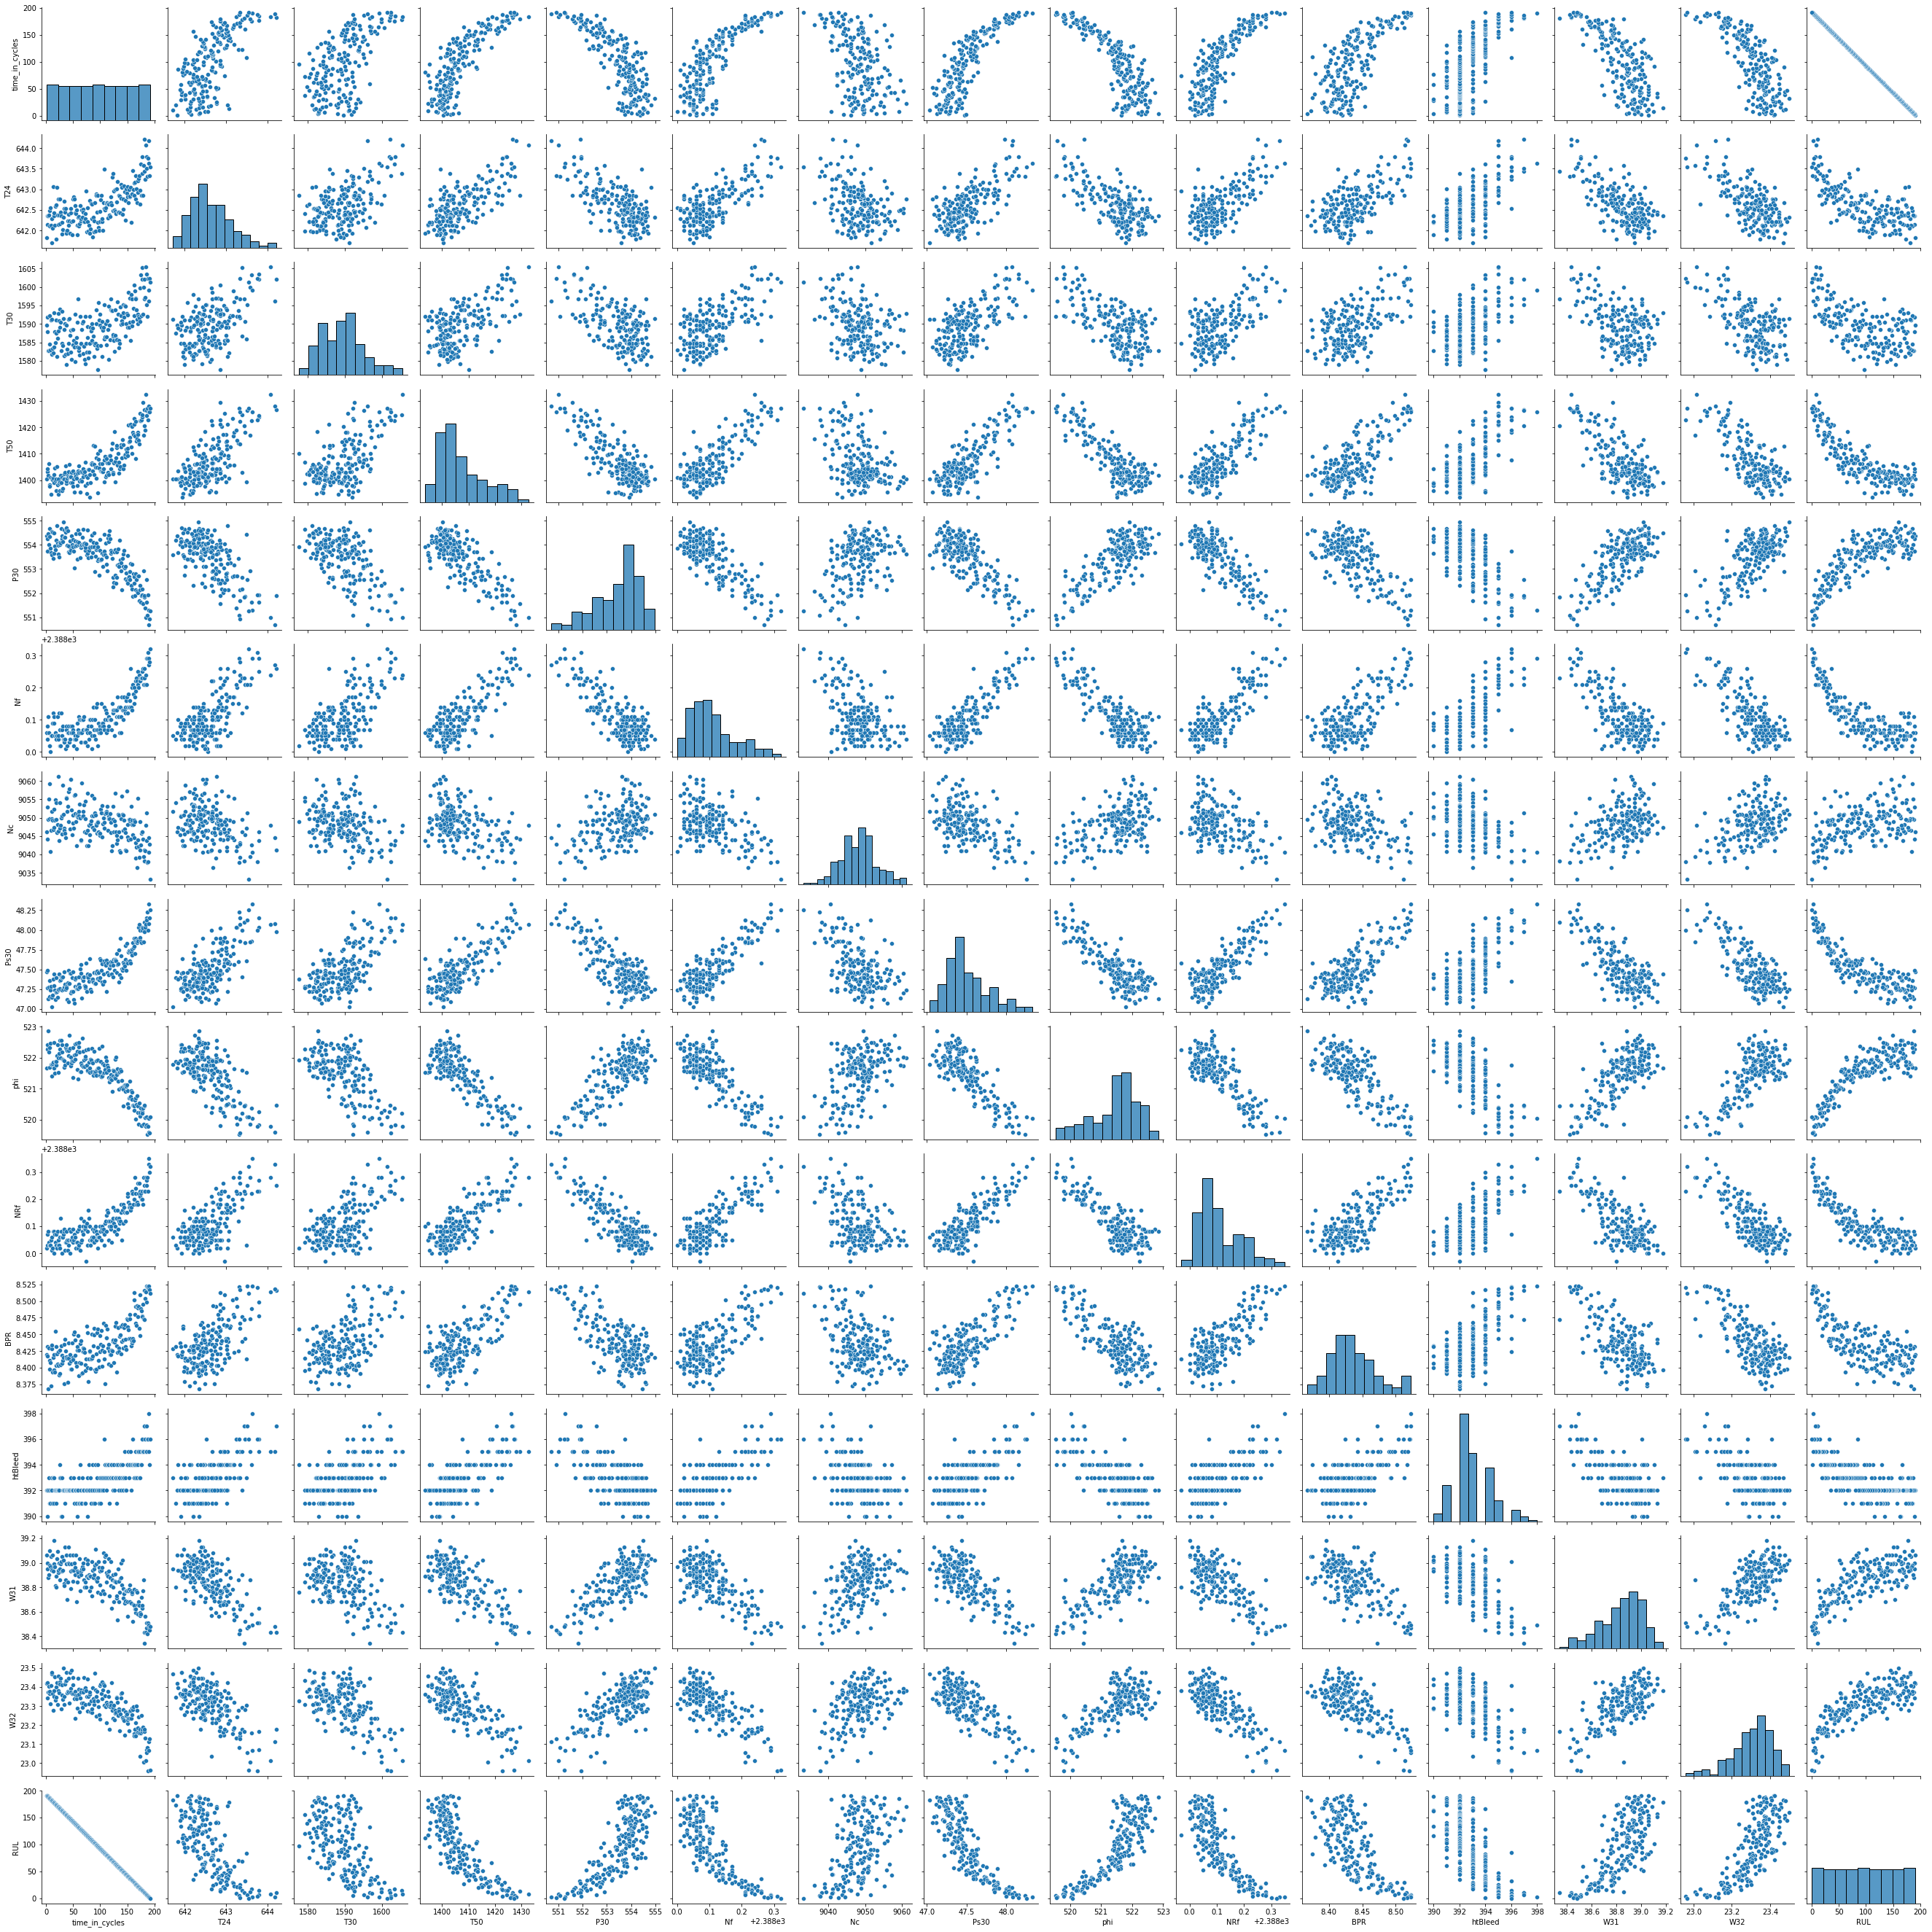

In [15]:
sns.pairplot(df1)
plt.show()

In [11]:
# generate label columns for training data
w1 = 30
w0 = 15
train_1['label1'] = np.where(train_1['RUL'] <= w1, 1, 0 )
train_1['label2'] = train_1['label1']
train_1.loc[train_1['RUL'] <= w0, 'label2'] = 2
train_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label1,label2
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0,0


In [12]:
# MinMax normalization
train_1['cycle_norm'] = train_1['time_in_cycles']
cols_normalize = train_1.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_1 = pd.DataFrame(min_max_scaler.fit_transform(train_1[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_1.index)
join_1 = train_1[train_1.columns.difference(cols_normalize)].join(norm_train_1)
train_1 = join_1.reindex(columns = train_1.columns)
train_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0,0.01108


In [21]:
test_1['cycle_norm'] = test_1['time_in_cycles']
norm_test_1 = pd.DataFrame(min_max_scaler.transform(test_1[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_1.index)
test_join_1 = test_1[test_1.columns.difference(cols_normalize)].join(norm_test_1)
test_1 = test_join_1.reindex(columns = test_1.columns)
test_1 = test_1.reset_index(drop=True)
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108


In [22]:
# generate column max for test data
rul = pd.DataFrame(test_1.groupby('unit_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_number', 'max']
rul_1.columns = ['more']
rul_1['unit_number'] = rul_1.index + 1
rul_1['max'] = rul['max'] + rul_1['more']
rul_1.drop('more', axis=1, inplace=True)

ValueError: ignored

In [23]:
# generate RUL for test data
test_1 = test_1.merge(rul_1, on=['unit_number'], how='left')
test_1['RUL'] = test_1['max'] - test_1['time_in_cycles']
test_1.drop('max', axis=1, inplace=True)
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108,138


In [24]:
# generate label columns w0 and w1 for test data
test_1['label1'] = np.where(test_1['RUL'] <= w1, 1, 0 )
test_1['label2'] = test_1['label1']
test_1.loc[test_1['RUL'] <= w0, 'label2'] = 2
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108,138,0,0


In [17]:
# pick a large window size of 50 cycles
sequence_length = 50

In [ ]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [25]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_1[test_1['unit_number'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

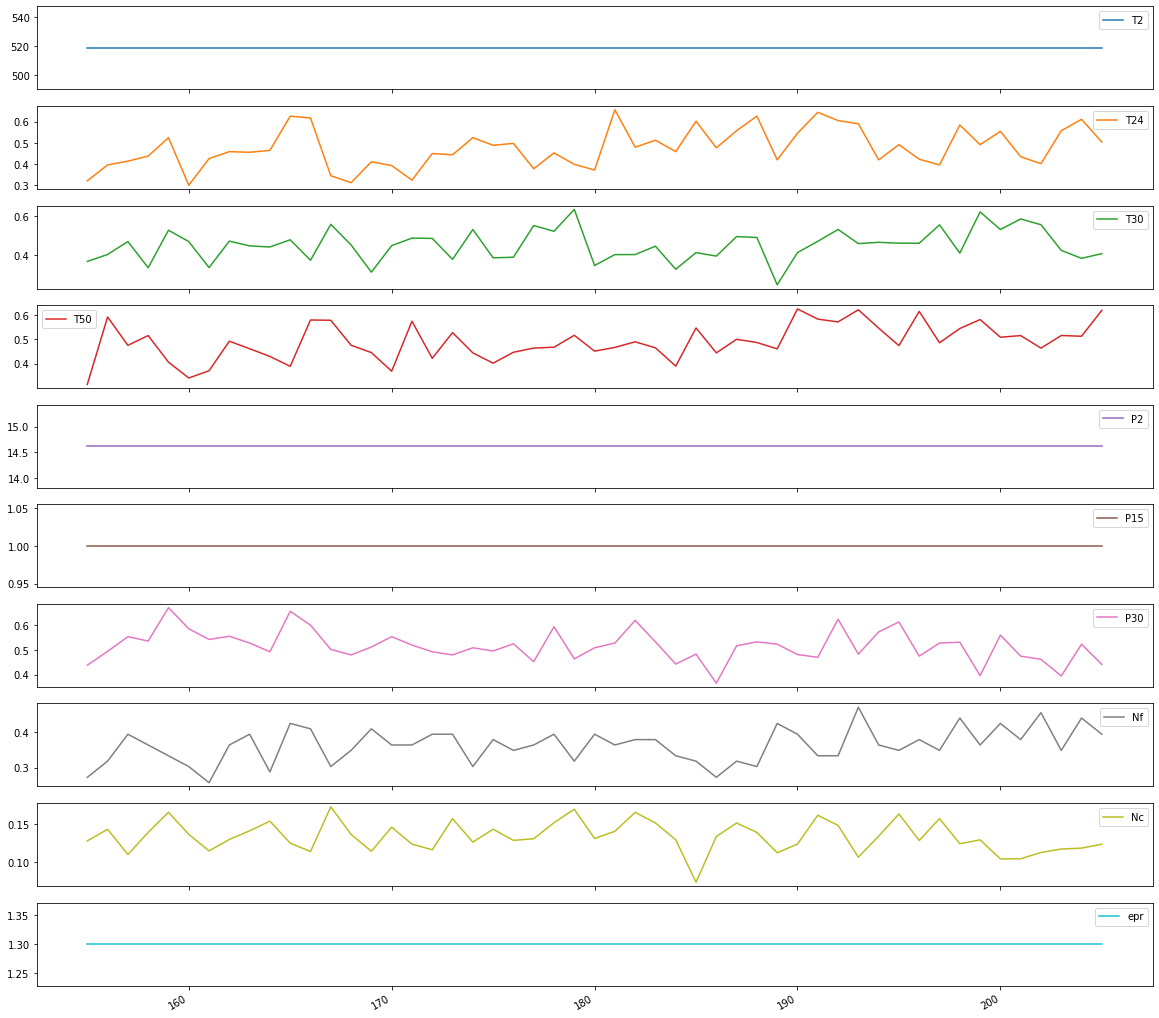

In [26]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

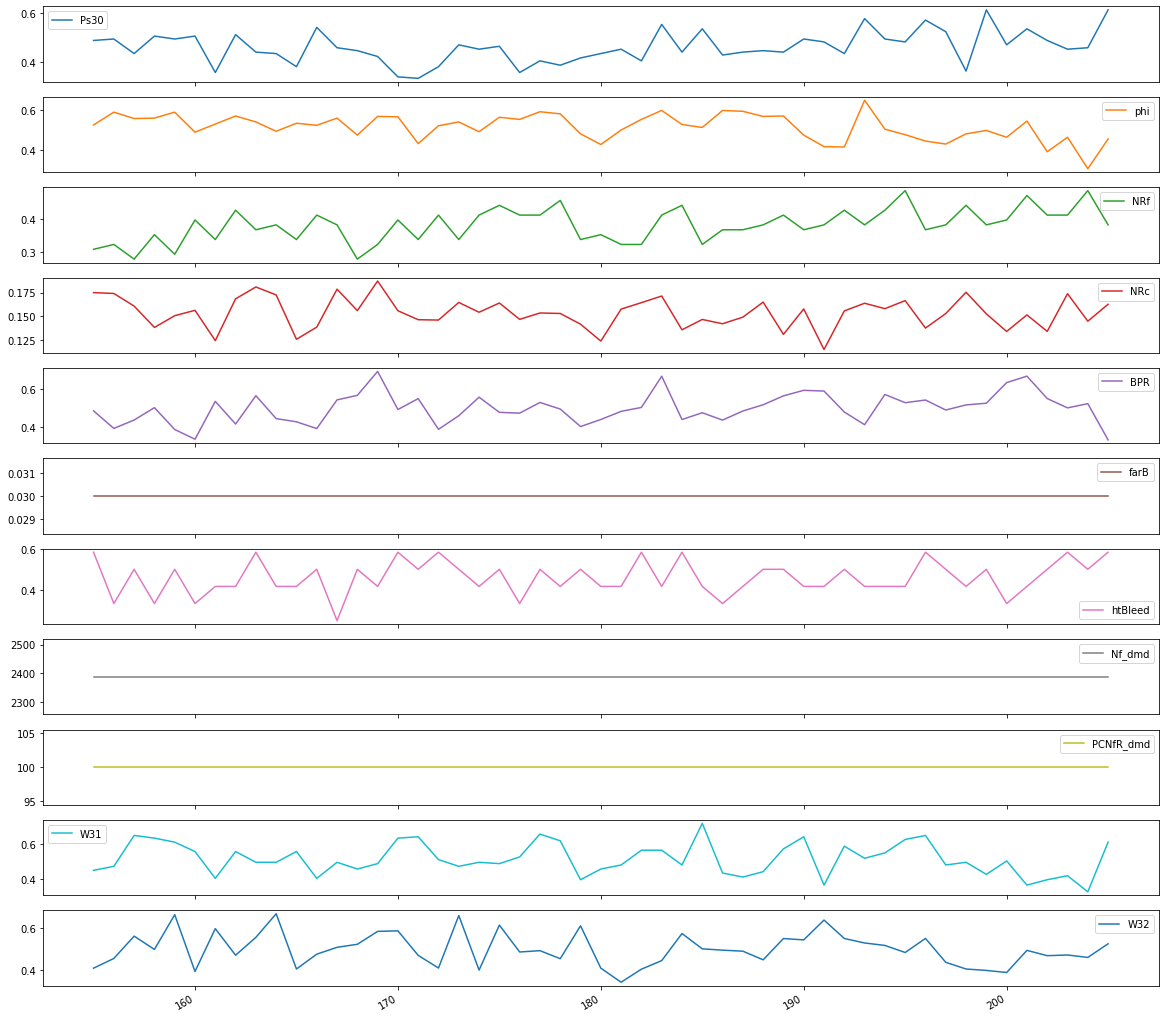

In [27]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [28]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [32]:
# pick the feature columns 
# sensor_cols = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
# sequence_cols = ['setting_1', 'setting_2', 'TRA', 'cycle_norm']
# sequence_cols.extend(sensor_cols)

In [35]:
sequence_cols = ['setting_1', 'setting_2', 'cycle_norm','T24','T30','T50','P15','P30','Nf','Nc','Ps30','phi','NRf','NRc','BPR','htBleed','W31','W32']

In [36]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_1[train_1['unit_number']==id], sequence_length, sequence_cols)) 
           for id in train_1['unit_number'].unique())

In [39]:
# train_1.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [38]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 18)

In [40]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [42]:
# generate labels
label_gen = [gen_labels(train_1[train_1['unit_number']==id], sequence_length, ['label1']) 
             for id in train_1['unit_number'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [43]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           47600     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
%%time
# fit the network
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
75/75 [==============================] - 12s 40ms/step - loss: 0.4080 - accuracy: 0.7883 - val_loss: 0.0781 - val_accuracy: 0.9680
Epoch 2/10
75/75 [==============================] - 2s 26ms/step - loss: 0.1001 - accuracy: 0.9597 - val_loss: 0.0676 - val_accuracy: 0.9706
Epoch 3/10
75/75 [==============================] - 2s 25ms/step - loss: 0.0852 - accuracy: 0.9640 - val_loss: 0.0351 - val_accuracy: 0.9923
Epoch 4/10
75/75 [==============================] - 2s 25ms/step - loss: 0.0677 - accuracy: 0.9736 - val_loss: 0.0812 - val_accuracy: 0.9642
CPU times: user 10.5 s, sys: 2.08 s, total: 12.6 s
Wall time: 17.5 s


In [46]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 9ms/step - loss: 0.0817 - accuracy: 0.9673
Accurracy: 0.9673085808753967


In [47]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 9ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12318,   213],
       [  298,  2802]])

In [48]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9293532338308458 
 recall =  0.9038709677419355


In [50]:
seq_array_test_last = [test_1[test_1['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_1['unit_number'].unique() if len(test_1[test_1['unit_number']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 18)

In [52]:
y_mask = [len(test_1[test_1['unit_number']==id]) >= sequence_length for id in test_1['unit_number'].unique()]

In [53]:
label_array_test_last = test_1.groupby('unit_number')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [54]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 18)
(93, 1)


In [55]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.1929 - accuracy: 0.9355
Accurracy: 0.9354838728904724


In [56]:
# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[67,  1],
       [ 5, 20]])

In [57]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.9523809523809523 
 Recall:  0.8 
 F1-score: 0.8695652173913043


In [58]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.935484,0.952381,0.8,0.869565
Template Best Model,0.940000,0.952381,0.8,0.869565


In [59]:
a = 0
while a != 1:
  b = 1

KeyboardInterrupt: ignored